
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units per building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

In [1]:
try:
    import urllib2 as urllib
except ImportError:
    import urllib as urllib

from __future__ import print_function

import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smg
import matplotlib.gridspec as gridspec

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
if not os.path.isfile(os.getenv("PUIDATA") + "/NYCenergy.csv"):
    url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
    urllib.request.urlretrieve(url, "NYCenergy.csv")
    ! mv NYCenergy.csv $PUIDATA

In [3]:
if not os.path.isfile(os.getenv("PUIDATA") + "/man_pluto/PLUTODD18v1.pdf"):
    url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
    urllib.request.urlretrieve(url, "man_pluto.zip")
    !unzip -d $PUIDATA/man_pluto man_pluto.zip

In [4]:
# load the building size as a geoDF and the local law 84 as a dataframe
nrg = pd.read_csv(os.getenv("PUIDATA") + "/NYCenergy.csv")

bsize = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/man_pluto/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

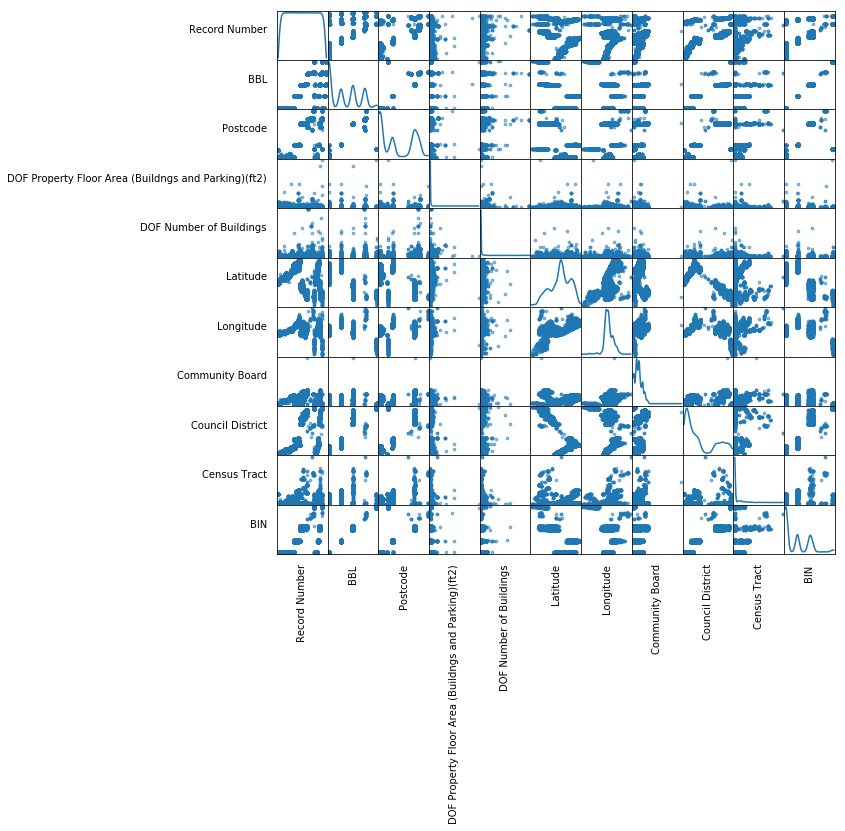

In [5]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')
n = 11
for x in range(n):
    for y in range(n):
        ax = sfig[x, y]
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 10
        ax.yaxis.label.set_horizontalalignment('right')

**Figure 1**: Scatter Matrix of energy consumption in NYC dataset with KDEs in the diagonal. This is not particularly useful. 

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [6]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [7]:
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

In [8]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [9]:
bsize = bsize[['BBL' , 'UnitsTotal', 'UnitsRes', 'YearBuilt', 'geometry']]

In [10]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [ ]:
#leave
bsize.head()

,BBL,UnitsTotal,UnitsRes,YearBuilt,geometry
0,1.015450e+09,18,16,1920,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,1.007238e+09,50,50,1914,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,1.016800e+09,10,10,1910,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,1.013850e+09,32,29,1928,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,1.011970e+09,26,26,1900,"POLYGON ((992273.6849975586 224863.4904174805,..."


In [ ]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')
n = 4
for x in range(n):
    for y in range(n):
        ax = sfig[x, y]
        ax.xaxis.set_label_coords(0.5, -0.3)
        ax.yaxis.set_label_coords(-0.5, 0.5)

**Figure 2**: Scatter Matrix for Manhattan Pluto data. There seems to be a positive correlation between UnitsRes and UnitsTotal which makes sense. There seems to be a number of buildings built in year 0, so there might be some errors in the data.


- BBL: NYC Borough, Block, and Lot.
- UnitsTotal: Sum of residential and non-residential (offices, retail stores, etc.) units in all buildings on the tax lot.
- UnitsRes: Sum of residential units in all buildings on the tax lot.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [ ]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],
                                                                       errors='coerce')

In [ ]:
nrg.dtypes

In [ ]:
bsize.dtypes

In [ ]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


In [ ]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

In [ ]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [ ]:
nrg.head()

In [ ]:
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg, how='outer', on='BBL')

In [ ]:
bblnrgdata = nrg.merge(bsize, how='outer', on='BBL')
bblnrgdata.drop(labels='geometry', axis=1, inplace=True)
bblnrgdata.dropna(axis=0, inplace=True)
bblnrgdata.reset_index(drop=True, inplace=True)
bblnrgdata.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Area (ft²)'}, inplace=True)
bblnrgdata.head()

# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [ ]:
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'])
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)'])
bblnrgdataGPD.dropna(axis=0, inplace=True)
bblnrgdataGPD.reset_index(drop=True, inplace=True)
bblnrgdataGPD.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Area (ft²)'}, inplace=True)
bblnrgdataGPD.head()

### Plotting for Log Floor Area (ft $^2$) and Log EUI

In [ ]:
fig = plt.figure(figsize=(10,20)) 

ax1 = fig.add_subplot(211)
ax1.set_axis_off()
ax1.set_title('Log Area (ft²) of Buildings in Manhattan')
bblnrgdataGPD.plot('logarea', legend=True, ax=ax1)
ax1.axes.set_aspect('auto', 'datalim')

ax2 = fig.add_subplot(212)
ax2.set_axis_off()
ax2.set_title('Log Energy Use Intensity (kBtu/ft²) of Buildings in Manhattan')
bblnrgdataGPD.plot('lognrg', legend=True, ax=ax2)
ax2.axes.set_aspect('auto', 'datalim')

**Figure 3**: Choropleths of area of buildings and energy use intensity in Manhattan. The first choropleth shows that there is variation in reported building floor areas but the second choropleth seems to indicate that the energy use intensity across buildings Manhattan are relatively similar. 

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [ ]:
bblnrgdata = bblnrgdata[bblnrgdata['Site EUI(kBtu/ft2)'] != 0]
bblnrgdata.head()

In [ ]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata['Area (ft²)'].astype(float) * bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
print('minimum building energy value %f' %min(bblnrgdata['nrg']))
print('maximum building energy value %f' %max(bblnrgdata['nrg']))

In [ ]:
fig = plt.figure(figsize=(12,12)) 

ax = fig.add_subplot(111)
ax.scatter(x='nrg', y='UnitsTotal', data=bblnrgdata)
ax.set_xlabel('Energy Consumption per Building (kBtu)', fontsize=15)
ax.set_ylabel('Number of Units in Building', fontsize=15)
ax.set_title('Units against Energy Consumption per building', fontsize=15)

**Figure 4**: This scatter plot of number of units against energy consumption per building is not very informative because outliers have not been removed.

In [ ]:
# removing outliers
bblnrgdata_plot = bblnrgdata[bblnrgdata['nrg'] < 0.6 * 1e8]
bblnrgdata_plot = bblnrgdata_plot[bblnrgdata_plot['UnitsTotal'] < 1000]
bblnrgdata_plot.head()

In [ ]:
print('original number of points: %i' %len(bblnrgdata['nrg']))
print('after removing outliers: %i' %len(bblnrgdata_plot['nrg']))
print('total number of points removed: %i' %(len(bblnrgdata['nrg'])-len(bblnrgdata_plot['nrg'])))

In [ ]:
fig = plt.figure(figsize=(12,12)) 

ax = fig.add_subplot(111)
ax.scatter(x='nrg', y='UnitsTotal', data=bblnrgdata_plot)
ax.set_xlabel('Energy Consumption per Building (kBtu)', fontsize=15)
ax.set_ylabel('Number of Units in Building', fontsize=15)
ax.set_title('Units against Energy Usage per building', fontsize=15)

**Figure 5**: Scatter plot after removing outliers. It seems like there is a possibility of a positive corrleation between the number of units in a building and the energy consumed by the building. 

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





In [ ]:
plt.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
plt.xlabel("x", fontsize=20)
plt.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [ ]:
bblnrgdata_log = bblnrgdata[(bblnrgdata['nrg'] >= 1000) & (bblnrgdata['nrg']<= 1e10)]
bblnrgdata_log = bblnrgdata_log[(bblnrgdata_log['UnitsTotal'] >= 1) & (bblnrgdata_log['UnitsTotal'] <= 1000)]

In [ ]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
bblnrgdata_log.plot(x='UnitsTotal', y='nrg', loglog=True, kind='scatter', ax=ax)
ax.set_xlabel('Units (Total)', fontsize=15)
ax.set_ylabel('Energy Consumption', fontsize=15)
ax.set_title('Energy Usage against Total Units per building', fontsize=15)

**Figure 6**: Scatter plot of energy consumption against total number of units per building. From 10 units onwards, there seems to be a possible positive correlation between energy consumption and total number of units per building. Meanwhile, for buildings with 10 units or less, there is a large variance in energy consumption.

In [ ]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
bblnrgdata_log.plot(x='nrg', y='UnitsTotal', loglog=True, kind='scatter', ax=ax)
ax.set_ylabel('Units (Total)', fontsize=15)
ax.set_xlabel('Energy Consumption', fontsize=15)
ax.set_title('Total Units against Energy Usage per building', fontsize=15)

**Figure 7**: Scatter plot of total number of units against energy consumption per building. It does not look like we can predict the total number of units in a building based on energy consumption of the building...

# Fit the data with a line in log space:  


## Model NRG as a linear function of number of units in the building 
Certainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**Answer**: It is intuitive to think that the number of units will affect energy consumption rather than the other way around (since these units have to exist before they can use energy!).

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

In [ ]:
# creating log columns for nrg and total units
bblnrgdata_log['logtotalunits'] = np.log10(bblnrgdata_log['UnitsTotal'])
bblnrgdata_log['logtotalnrg'] = np.log10(bblnrgdata_log['nrg'])
bblnrgdata_log.head()

### Units vs Energy

In [ ]:
ols1_model = smf.ols(formula='logtotalunits ~ logtotalnrg', data=bblnrgdata_log)
fitted_ols1_model = ols1_model.fit()
fitted_ols1_model.summary()

In [ ]:
# extracting parameters
ols1_int, ols1_coeff = fitted_ols1_model.params

# creating array of x values to plot line
xvalues = linspace(start=min(bblnrgdata_log['logtotalnrg']), stop=max(bblnrgdata_log['logtotalnrg']), num=50)

# creating funciton of linear model
ols1_mod = ols1_int + ols1_coeff*xvalues

In [ ]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
scatter = ax.scatter(x=bblnrgdata_log['logtotalnrg'], y=bblnrgdata_log['logtotalunits'], s=15)
ax.plot(xvalues, ols1_mod, color='black', label='OLS fit')
ax.set_ylabel("Total Units per Building", fontsize=15)
ax.set_xlabel("Energy Consumption", fontsize=15)
ax.set_title("Total Units against Energy Linear Model", fontsize=15)
ax.legend(loc="upper right")
ax.set_ylim()

**Figure 8**: A best fit line is plotted on the scatter plot of total units against energy consumption. However, the linear model does not seem to be a good explanation for the data.

### Energy against Units

In [ ]:
ols2_model = smf.ols(formula='logtotalnrg ~ logtotalunits', data=bblnrgdata_log)
fitted_ols2_model = ols2_model.fit()
fitted_ols2_model.summary()

In [ ]:
# extracting parameters
ols2_int, ols2_coeff = fitted_ols2_model.params

# creating array of x values to plot line
xvalues2 = linspace(start=min(bblnrgdata_log['logtotalunits']), stop=max(bblnrgdata_log['logtotalunits']), num=50)

# creating funciton of linear model
ols2_mod = ols2_int + ols2_coeff*xvalues2

In [ ]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
scatter = ax.scatter(x=bblnrgdata_log['logtotalunits'], y=bblnrgdata_log['logtotalnrg'], s=15, label='')
ax.plot(xvalues2, ols2_mod, color='black', label='OLS fit')
ax.set_xlabel("Total Units per Building", fontsize=15)
ax.set_ylabel("Energy Consumption", fontsize=15)
ax.set_title("Energy against Total Units Linear Model", fontsize=15)
ax.legend(loc="upper right")
ax.set_ylim()

**Figure 9**: A best fit line is plotted on the scatter plot of energy consumption against total units. This linear model seems to provide a better explanation of the data compared to the previous linear model.

In [ ]:
print('R-Squared Value for Units against Energy Model: %f' %fitted_ols1_model.rsquared)
print('R-Squared Value for Energy against Units Model: %f' %fitted_ols2_model.rsquared)

print('Log-Likelihood for Units against Energy Model: %f'  %fitted_ols1_model.llf)
print('Log-Likelihood for Energy against Units Model: %f' %fitted_ols2_model.llf)

Both models have the same R-Squared value which makes sense because it is a measure of correlation. However, there is a difference in the log-likelihood of the two models - the Energy against Units Model has log-likelihood that is closer to zero than the Units against Energy Model. This indicates that the Energy against Units Model is a better model, i.e. Total Units is the independent variable and Energy Consumption is the dependent variable rather than the other way round.

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [ ]:
bblnrgdata_log['logtotalunits_2'] = bblnrgdata_log['logtotalunits']**2

In [ ]:
ols3_model = smf.ols(formula='logtotalnrg ~ logtotalunits + logtotalunits_2', data=bblnrgdata_log)
fitted_ols3_model = ols3_model.fit()
fitted_ols3_model.summary()

In [ ]:
# extracting parameters
ols3_int, ols3_coeff, ols3_coeff_2 = fitted_ols3_model.params

# creating array of x values to plot line
xvalues2 = linspace(start=min(bblnrgdata_log['logtotalunits']), stop=max(bblnrgdata_log['logtotalunits']), num=50)

# creating funciton of linear model
ols3_mod = ols3_int + ols3_coeff*xvalues2 + ols3_coeff_2*(xvalues2**2)

In [ ]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)
scatter = ax.scatter(x=bblnrgdata_log['logtotalunits'], y=bblnrgdata_log['logtotalnrg'], s=15, label='')
ax.plot(xvalues2, ols3_mod, color='black', label='OLS fit')
ax.set_xlabel("Total Units per Building", fontsize=15)
ax.set_ylabel("Energy Consumption", fontsize=15)
ax.set_title("Energy against Total Units Linear Model", fontsize=15)
ax.legend(loc="upper right")
ax.set_ylim()

**Figure 10**: A plot of the second degree polynomial model seems to indicate that it is a better model than the best fit line. The second degree polynomial fit also has a higher R-squared value and a log-likelihood closer to 0, compared to the model with degree one.

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [ ]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: series of errors (optional). 
    If errors are not passed all errors are set to 1
    '''
    if errors is None:
        ones = pd.Series(data=np.ones(len(data)))
        return sum((model - data)**2/(ones**2))
    else:
        return sum((model - data)**2/(errors**2))

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [ ]:
def err(x):
    return np.sqrt(x)

In [ ]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured quantities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities

nrg_err_num = np.sqrt(err(bblnrgdata_log['Site EUI(kBtu/ft2)'])**2 + err(bblnrgdata_log['Area (ft²)'])**2)
nrg_err_denom = bblnrgdata_log['Site EUI(kBtu/ft2)']*bblnrgdata_log['Area (ft²)']*np.log(10)
bblnrgdata_log['errorslognrg'] = nrg_err_num/nrg_err_denom

units_err_num = err(bblnrgdata_log['logtotalunits'])
units_err_denom = bblnrgdata_log['logtotalunits']*np.log(10)
bblnrgdata_log['errorslogunits'] = units_err_num/units_err_denom

In [ ]:
bblnrgdata_log.head()

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

In [ ]:
#I could also include errors for number of units
fig2 = plt.figure(figsize=(20,20))

gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdata_log.UnitsTotal), np.log10(bblnrgdata_log.nrg), 
            yerr=bblnrgdata_log.errorslognrg, fmt='.',
            alpha=0.5)
ax1.set_xlabel("log10 of Units", fontsize=15)
ax1.set_ylabel("log10 Energy", fontsize=15)
ax1.set_title("Plot with Y errors only")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdata_log.UnitsTotal), np.log10(bblnrgdata_log.nrg), 
            xerr=bblnrgdata_log.errorslogunits, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)
ax2.set_title("Plot with X errors only")


ax3 = plt.subplot2grid((3,3), (1, 0), rowspan = 2, colspan=2)
ax3.errorbar(np.log10(bblnrgdata_log.UnitsTotal), np.log10(bblnrgdata_log.nrg), 
            yerr=bblnrgdata_log.errorslognrg,
           xerr=bblnrgdata_log.errorslogunits, alpha=0.5, fmt='.')
ax3.set_xlabel("log10 of Units", fontsize=15)
ax3.set_ylabel("log10 Energy", fontsize=15)
ax3.set_title("Both X and Y errors")

print ("The largest error bar is for")
bblnrgdata_log[bblnrgdata_log.errorslognrg == bblnrgdata_log.errorslognrg.max()]


**Figure 11**: Scatter plot of energy against units with errorbars. In the top panel, the x errors and y errors are plotted individually. In the bottom panel, the x and y errors are plotted. Because the y errors (energy errors) are much smaller than the actual y values, they do not show up obviously on the plots.

Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [ ]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgdata_log['nrg'])-2
print ("degrees of freedom:" , dof)

In [ ]:
ols1_predicted = pd.Series(data=fitted_ols1_model.predict())
ols2_predicted = pd.Series(data=fitted_ols2_model.predict())

In [ ]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata_log.UnitsTotal), ols1_predicted) / dof))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata_log.UnitsTotal), ols1_predicted, 
            errors = bblnrgdata_log.errorslognrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata_log.UnitsTotal), ols1_predicted, 
            errors = np.sqrt(bblnrgdata_log.errorslognrg**2 + 
                             bblnrgdata_log.errorslogunits**2))  / dof))


In [ ]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata_log.nrg), ols2_predicted) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata_log.nrg), ols2_predicted, 
            errors = bblnrgdata_log.errorslognrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata_log.nrg), ols2_predicted, 
            errors = np.sqrt(bblnrgdata_log.errorslognrg**2 + 
                             bblnrgdata_log.errorslogunits**2))  / dof))


### Compare the models using the chi square:
The Units vs Energy chi square per DOF and residuals is higher than the Energy vs Units chi square per DOF and residuals, indicating that the Units vs Energy model is a poorer model than the Energy vs Units model. However, for the chi square per DOF with independent variable error only, the Units vs Energy model seems to perform better than the Energy vs Units model with a lower chi-square.

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

In [ ]:
fig = plt.figure(figsize=(20,10)) 

ax1 = fig.add_subplot(121)
smg.regressionplots.influence_plot(fitted_ols1_model, ax=ax1)
ax1.set_title('Influence Plot for Units vs Energy Model', fontsize=15)
;

ax2 = fig.add_subplot(122)
smg.regressionplots.influence_plot(fitted_ols2_model, ax=ax2)
ax2.set_title('Influence Plot for Energy vs Units Model', fontsize=15)
;

**Figure 12**: The influence plot for the Units against Energy Model shows a smaller spread (-4 to 3) compared to the Energy against Units Model (-8 to 8), indicating that is a poorer predictive model.

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit of the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [ ]:
lr_results = fitted_ols3_model.compare_lr_test(fitted_ols2_model)

In [ ]:
print('degree of freedom: %f' %lr_results[2])
print('LR Stat: %f' %lr_results[0])
print('p-value: %f' %lr_results[1])

At a significance level of 0.05, the Chi-Square statistic with 1 degree of freedom is 3.841. The LR stat is 755.811785, which is much higher than 3.841. This means that the p-value is less than 0.05, so we can reject the null hypothesis that the restricted model (linear fit) is a better model than the alternative model (quadratic fit), i.e. the better model is the quadratic model. Alternatively, we can just look at the p-value of 0.000000 and conclude that since the p-value < 0.05, we can reject the null hypothesis.

## EXTRA CREDIT: a plot of anything related to these data

In [ ]:
data_year = bblnrgdata.groupby(by='YearBuilt').sum()
data_year.drop(axis=0, labels=0, inplace=True)
data_year.reset_index(inplace=True)
data_year.head()

In [ ]:
data_year['nrg_avg'] = data_year['nrg']/data_year['Area (ft²)']
data_year = data_year[data_year['YearBuilt']>=1950]
data_year = data_year[data_year['nrg_avg']<20000]
data_year.head()

In [ ]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
ax.scatter(x='YearBuilt', y='nrg_avg', data=data_year)
ax.set_title('Average Energy Usage against Year Built')
ax.set_ylabel('Average Energy')
ax.set_xlabel('Year')